In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re
import string
import copy
import datetime
import traceback
import random
from collections import Counter
from IPython.display import clear_output
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [5]:
class Vocabulary:
    
    def __init__(self, token2index=None, add_unk=True, unk_token="<UNK>"):
        if token2index is None:
            token2index = {}
        self._token2index = token2index
        self._add_unk = add_unk
        self._unk_token = unk_token
        self._index2token = {index: token for token, index in self._token2index.items()}
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)
            
    def add_token(self, token):
        if token in self._token2index:
            index = self._token2index[token]
        else:
            index = len(self._token2index)
            self._token2index[token] = index
            self._index2token[index] = token
        return index
        
    def lookup_token(self, token):
        if self._add_unk:
            return self._token2index.get(token, self.unk_index)
        else:
            return self._token2index[token]
        
    def lookup_index(self, index):
        if index not in self._index2token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._index2token[index]
    
    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)
    
    def to_serializable(self):
        return {
            'token_to_idx': self._token2index,
            'add_unk': self._add_unk,
            'unk_token': self._unk_token
        }
        
    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)
    
    def __len__(self):
        return len(self._token2index)


class ReviewVectorizer:
    
    def __init__(self, review_vocab, rating_vocab):
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab
    
    def vectorize(self, review):
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)
        for token in review.split(" "):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1
        return one_hot

    @classmethod
    def from_dataframe(cls, dataframe, config):
        review_vocab = Vocabulary(add_unk=True)
        rating_vocab = Vocabulary(add_unk=False)
        # Добавить рейтинги
        for rating in sorted(set(dataframe['sentiment'])):
            rating_vocab.add_token(rating)
        # Добавить часто встречающиеся слова, если число вхождений
        # больше указанного
        word_counts = Counter()
        for review in dataframe['review']:
            for word in review.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
        for word, count in word_counts.items():
            if count > config.cutoff:
                review_vocab.add_token(word)
        return cls(review_vocab, rating_vocab)


class ReviewDataset(Dataset):
    
    def __init__(self, config, dataframe, vectorizer):
        self.review_df = dataframe
        self.train_df, self.test_df = train_test_split(dataframe, test_size=config.test_size, random_state=config.randon_seed)
        self.train_size = len(self.train_df)
        self.test_size = len(self.test_df)
        self._vectorizer = vectorizer
        self._lookup_dict = {
            'train': (self.train_df, self.train_size),
            'test': (self.test_df, self.test_size)
        }
        self._target_split = None
        self._target_df = None
        self._target_size = None
        self.set_split('train')
        
    def __len__(self):
        return self._target_size
    
    def __getitem__(self, index):
        row = self._target_df.iloc[index]
        return {
            'text': self._vectorizer.vectorize(row['review']),
            'target': self._vectorizer.rating_vocab.lookup_token(row['sentiment'])
        }
    
    def set_split(self, split='train'):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]
    
    def get_vectorizer(self):
        return self._vectorizer
    
    def get_num_batches(self, batch_size):
        return len(self) // batch_size
    
    @classmethod
    def load_dataset_and_make_vectorizer(cls, config):
        review_df = pd.read_csv(config.dataset_file)
        review_df["review"] = review_df["review"].apply(preprocess_text)
        return cls(config, review_df, ReviewVectorizer.from_dataframe(review_df, config))

In [6]:
def set_random_seed(value=0, cuda=True):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    if cuda:
        torch.cuda.manual_seed(value)
        torch.backends.cudnn.deterministic = True

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [7]:
def generate_batches(dataset, batch_size, shuffle=True, drop_last=True, device="cpu"):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [8]:
def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [9]:
class ReviewClassifier(nn.Module):
    
    def __init__(self, num_features):
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, out_features=1)
 
    def forward(self, x_in, apply_sigmoid=False):
        # x_in.shape = (batch, num_features)
        y_out = self.fc1(x_in).squeeze()
        if apply_sigmoid:
            y_out = torch.sigmoid(y_out)
        return y_out

In [10]:
def model_size(model):
    print(model)
    print("All parameters: ", sum(p.numel() for p in model.parameters()))
    print("Trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [11]:
class ConfigClassification:
    randon_seed = 42
    root = "../../data/raw/_classification_text/"
    dataset_file = "../../data/raw/_classification_text/IMDB Dataset.csv"
    test_size = 0.3
    batch_size = 64
    cutoff = 3
    model_state_file='model.pth'
    save_dir='model_storage/'
    vectorizer_file='vectorizer.json'
    batch_size=128
    early_stopping_criteria=5
    learning_rate=0.001
    num_epochs=100
    cuda=True
    loss_func=None
    optimizer=None
    scheduler=None
    dataloader_workers_n=12
    early_stopping_patience=5

In [12]:
config = ConfigClassification()

In [13]:
if not torch.cuda.is_available():
    config.cuda = False
config.device = torch.device("cuda" if config.cuda else "cpu")

In [14]:
set_random_seed(config.randon_seed, config.cuda)

In [15]:
%%time

dataset = ReviewDataset.load_dataset_and_make_vectorizer(config)

CPU times: user 13.6 s, sys: 113 ms, total: 13.8 s
Wall time: 13.8 s


In [16]:
vectorizer = dataset.get_vectorizer()

In [17]:
classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab))

In [18]:
config.loss_func = nn.BCEWithLogitsLoss()
config.optimizer = optim.Adam(classifier.parameters(), lr=config.learning_rate)
config.scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=config.optimizer, mode='min', factor=0.5, patience=5)

In [19]:
model_size(classifier)

ReviewClassifier(
  (fc1): Linear(in_features=43718, out_features=1, bias=True)
)
All parameters:  43719
Trainable parameters:  43719
Model's state_dict:
fc1.weight 	 torch.Size([1, 43718])
fc1.bias 	 torch.Size([1])


In [20]:
def train_eval_loop(model, dataset, config):
    model = model.to(config.device)
    optimizer = config.optimizer
    scheduler = config.scheduler
    criterion = config.loss_func
    
    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)
    
    history_mean_train_loss = []
    history_mean_val_loss = [] 

    dataset.set_split('train')
    train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(config.batch_size), position=1, leave=True)

    dataset.set_split('test')
    val_bar = tqdm(desc='split=test', total=dataset.get_num_batches(config.batch_size), position=1, leave=True)

    for epoch_i in tqdm(range(config.num_epochs), desc='training routine',  total=config.num_epochs, position=0):
        try:
            epoch_start = datetime.datetime.now()
            print(f'Epoch {epoch_i}')
            dataset.set_split('train')
            train_dataloader = generate_batches(dataset, batch_size=config.batch_size, device=config.device)
            running_loss = 0.0
            running_acc = 0.0
            
            classifier.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_index, batch_dict in enumerate(train_dataloader):
                # Процедура обучения состоит из пяти шагов:
                # Шаг 1. Обнуляем градиенты
                optimizer.zero_grad()
                # Шаг 2. Вычисляем выходные значения
                y_pred = classifier(x_in=batch_dict['text'].float())
                # Шаг 3. Вычисляем функцию потерь
                loss = criterion(y_pred, batch_dict['target'].float())
                loss_batch = loss.item()
                running_loss += (loss_batch - running_loss) / (batch_index + 1)
                # Шаг 4. Получаем градиенты на основе функции потерь
                loss.backward()
                # Шаг 5. Оптимизатор обновляет значения параметров по градиентам
                optimizer.step()
                # -----------------------------------------
                # Вычисляем точность
                acc_batch = compute_accuracy(y_pred, batch_dict['target'])
                running_acc += (acc_batch - running_acc) / (batch_index + 1)

                train_bar.set_postfix(loss=running_loss, 
                                  acc=running_acc, 
                                  epoch=epoch_i)
                train_bar.update()
                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            
            print('Epoch: {}, {:0.2f} сек'.format(epoch_i, (datetime.datetime.now() - epoch_start).total_seconds()))
            
            running_loss = 0.
            running_acc = 0.
            mean_val_loss = 0
            val_batches_n = 0
            classifier.eval()
            dataset.set_split('test')
            val_dataloader = generate_batches(dataset, batch_size=config.batch_size, device=config.device)
            with torch.no_grad():
                for batch_index, batch_dict in enumerate(val_dataloader):
                    # Шаг 1. Вычисляем выходные значения
                    y_pred = classifier(x_in=batch_dict['text'].float())
                    # Шаг 2. Вычисляем функцию потерь
                    loss = criterion(y_pred, batch_dict['target'].float())
                    loss_batch = loss.item()
                    running_loss += (loss_batch - running_loss) / (batch_index + 1)
                    # Шаг 3. Вычисляем точность
                    acc_batch = compute_accuracy(y_pred, batch_dict['target'])
                    running_acc += (acc_batch - running_acc) / (batch_index + 1)

                    val_bar.set_postfix(loss=running_loss, 
                                acc=running_acc, 
                                epoch=epoch_i)
                    val_bar.update()
                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            
            history_mean_train_loss.append(mean_train_loss)
            history_mean_val_loss.append(mean_val_loss)
            
            train_bar.n = 0
            val_bar.n = 0
            
            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > config.early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format( config.early_stopping_patience))
                break
    
            # visualizing training process
            if (epoch_i + 1) % 2 == 0:
                clear_output(True)
                plt.plot(history_mean_train_loss, label='train_loss')
                plt.plot(history_mean_val_loss, label='valid_loss')
                plt.legend()
                plt.show()
                
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break
            
    return best_val_loss, best_model

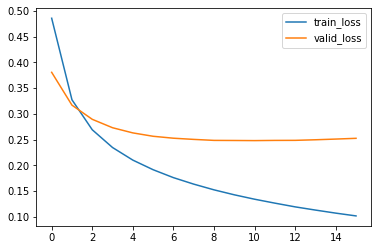

Epoch 16
Epoch: 16, 16.21 сек
Модель не улучшилась за последние 5 эпох, прекращаем обучение


In [21]:
best_val_loss, best_model = train_eval_loop(classifier, dataset, config)

In [22]:
dataset.set_split('test')
batch_generator = generate_batches(dataset, batch_size=config.batch_size, device=config.device)
running_loss = 0.
running_acc = 0.
classifier.eval()
for batch_index, batch_dict in enumerate(batch_generator):
    # вычисление выходных значений
    y_pred = classifier(x_in=batch_dict['text'].float())
    # вычисление потерь
    loss = config.loss_func(y_pred, batch_dict['target'].float())
    loss_batch = loss.item()
    running_loss += (loss_batch - running_loss) / (batch_index + 1)
    # вычисление точности
    acc_batch = compute_accuracy(y_pred, batch_dict['target'])
    running_acc += (acc_batch - running_acc) / (batch_index + 1)

print("Test loss: {:.3f}".format(running_loss))
print("Test Accuracy: {:.2f}".format(running_acc))

Test loss: 0.254
Test Accuracy: 89.96


In [23]:
# Сортировка весов
fc1_weights = classifier.fc1.weight.detach()[0]
_, indices = torch.sort(fc1_weights, dim=0, descending=True)
indices = indices.cpu().numpy().tolist()
# Топ-20 позитивных слов
print("Influential words in Positive Reviews:")
print("--------------------------------------")
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))

Influential words in Positive Reviews:
--------------------------------------
refreshing
excellent
superb
amazing
absorbing
underrated
fantastic
excellently
brilliant
gem
perfect
hooked
enjoyed
great
wonderfully
loved
email
hilarious
funniest
pleased


In [26]:
# Топ-20 негативных слов
print("Influential words in Negative Reviews:")
print("--------------------------------------")
indices.reverse()
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))

Influential words in Negative Reviews:
--------------------------------------
waste
worst
awful
poorly
unfunny
disappointing
boring
disappointment
fails
lacks
dreadful
forgettable
terrible
stinker
mst
unwatchable
laughable
uninteresting
wasting
pretentious


In [24]:
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             ...
#             }, PATH)

In [25]:
# model = TheModelClass(*args, **kwargs)
# optimizer = TheOptimizerClass(*args, **kwargs)

# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.eval()
# # - or -
# model.train()